In [1]:
#| default_exp mode_estimation
import matplotlib.pyplot as plt

# Mode estimation for log-concave state space models


Consider an [LCSSM](20_lcssm.ipynb) with states $X$ and observations $Y$.
If the joint distribution of $X$ and $Y$ is not gaussian, we are unable to perform the standard [Kalman filter and smoother](10_kalman_filter_smoother.ipynb).

Here we implement the alternative mode estimation method from [@Durbin2012Time], Chapter 10.6. It's main idea is to approximate the posterior distribution by a gaussian distribution by a second-order Taylor expansion for the log-pdf.

This essentially means matching the first and second order derivatives of the observation log-likelihoods at the mode. As the mode is a (global) maximum of the posterior distribution, we can find it by a Newton-Raphson iteration for which [@Durbin2012Time] show, that it can be implemented efficiently by a single pass of a Kalman smoother. 

The mode estimation procedure is based on the observation that at the mode $\hat s = (\hat s_0, \dots, \hat s_n)$ the surrogate gaussian model with the same state equation and observation equations

$$
\begin{align*}
S_t &= B_t X_t \\
Z_t &= S_t + \eta_t \\
\eta_t &\sim \mathcal N\left(0, \Omega_t\right)
\end{align*}
$$
for $\Omega_t^{-1} = -\frac{\partial^2 \log p(y_t|\cdot)}{\partial (s_t)^2}|_{\hat s_t}$ has, for $z_t = s_t +\Omega_t {\partial p(y_t|\cdot)}{\partial s_t}|_{\hat s_t}$ mode $\hat s$.

In most cases we are interested in, the observations are conditionally independent given the signals such that $\Omega$ is a **diagonal matrix**, which makes inversion much faster as we only have to invert the diagonals. This implementation assumes this to hold, but could be extended to handel the general case as well (replace the calls to `vdiag` by `solve`).

This is used in a fixed point iteration:

1. Start with an initial guess $\hat s$.
2. Setup the above gaussian approximation.
3. Perform a pass of the Kalman smoother, obtaining the posterior mode $\hat s^+$.
4. Set $\hat s = \hat s^+$ and iterate until convergence.

::: {.callout-note}
# Todo
Implement this with disturbance smoother (more efficient)
:::

In [2]:
#| code-fold: true
import fastcore.test as fct
from isssm.glssm import simulate_glssm
from isssm.glssm_models import lcm
import jax.random as jrn
from isssm.kalman import kalman

In [3]:
#| hide
from functools import partial
from jax import jit, vmap
import jax.numpy as jnp

In [4]:
#| hide
# should we jit + partial the application of B in mode_estimation?

vmm = vmap(jnp.matmul)

M = jrn.normal(jrn.PRNGKey(34234), (100, 200, 200))
x = jrn.normal(jrn.PRNGKey(34234), (100, 200))

vM = partial(vmm, M)
jvM = jit(partial(vmm, M))
jvmm = jit(vmm)

#%timeit vM(x).block_until_ready()
#%timeit jvM(x).block_until_ready()
#%timeit vmm(M,x).block_until_ready()
#%timeit jvmm(M,x).block_until_ready()
# seems jvmm/jvM is the fastest

2.84 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.85 ms ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.12 ms ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.93 ms ± 18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
#| export

from isssm.kalman import predict
from jaxtyping import Array, Float
from jax import grad, vmap, jacfwd, jacrev
from functools import partial
import jax.numpy as jnp
import jax.random as jrn

from isssm.typing import InitialState

from isssm.lcssm import nb_lcssm, simulate_lcssm, v_time
from jax.lax import scan
from isssm.kalman import smoother, kalman
from isssm.lcssm import v_time
from jax import grad, jacfwd, jacrev, jit

vmm = jit(vmap(jnp.matmul))
vdiag = jit(vmap(jnp.diag))

SmoothState = Float[Array, "n+1 m"]
PseudoObs = Float[Array, "n+1 p"]
PseudoObsCov = Float[Array, "n+1 p p"]

def mode_estimation(
    y: Float[Array, "n+1 p"], # observation
    x0: InitialState, # initial state mean
    A: Float[Array, "n m m"], # state transition matrices
    Sigma: Float[Array, "n+1 m m"], # state covariance matrices
    B: Float[Array, "n+1 p m"], # observation matrices
    xi_fun, # function mapping time and signal to parameters
    dist, # distribution of observations
    s_init: Float[Array, "n+1 p"], # initial signal
    n_iter: int, # number of iterations
    log_lik=None, # log likelihood function
    d_log_lik=None, # derivative of log likelihood function
    dd_log_lik=None, # second derivative of log likelihood function
) -> tuple[SmoothState, PseudoObs, PseudoObsCov]:
    np1, _ = y.shape
    n = np1 - 1

    def default_log_lik(t, s):
        params = xi_fun(t, s)
        return dist(params).log_prob(y[t]).sum()

    if log_lik is None:
        log_lik = jit(default_log_lik)

    if d_log_lik is None:
        d_log_lik = jit(jacfwd(log_lik, argnums=1))
    if dd_log_lik is None:
        dd_log_lik = jit(jacrev(d_log_lik, argnums=1))

    vd_log_lik = v_time(d_log_lik)
    vdd_log_lik = v_time(dd_log_lik)

    vB = jit(partial(vmm, B))

    def iteration(carry, input):
        (signal,) = carry

        grad = vd_log_lik(jnp.arange(n + 1), signal)
        Gamma = -vdd_log_lik(jnp.arange(n + 1), signal)
        # assume hessian is diagonal
        Omega = vdiag(1.0 / vdiag(Gamma))

        z = signal + vmm(Omega, grad)
        x_filt, Xi_filt, x_pred, Xi_pred = kalman(z, x0, Sigma, Omega, A, B)

        x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)

        signal = vB(x_smooth)

        return (signal,), (x_smooth, z, Omega)

    _, (x_smooth, z, Omega) = scan(iteration, (s_init,), (jnp.arange(n_iter),))

    return (x_smooth[-1], z[-1], Omega[-1])

We return to the [Negative Binomial common factor model](20_lcssm.ipynb#Negative_Binomial_Common_Factor_Model) and use mode estimation to obtain an estimate for the mode of the conditional distribution of states given the observations.

/usr/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:127: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  samps = jaxrand.gamma(


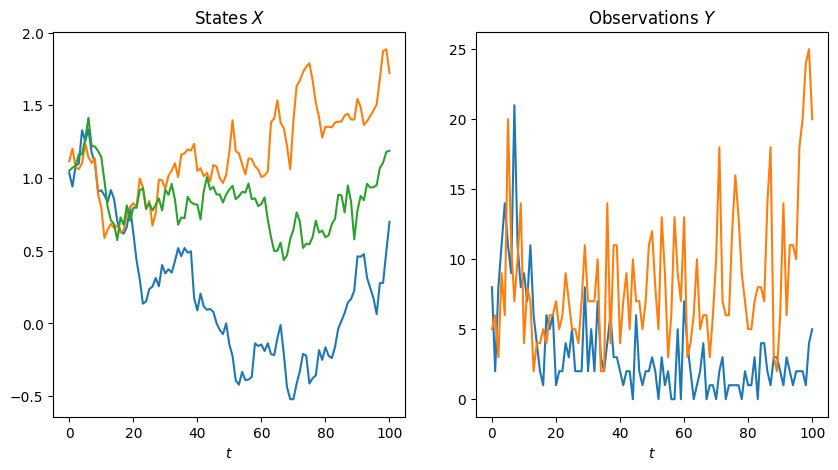

In [6]:
m, p, n = 3, 2, 100
A = jnp.broadcast_to(jnp.eye(m), (n, m, m))
B = jnp.broadcast_to(jnp.array([[1, 0, 1], [0, 1, 1]]), (n + 1, p, m))

s2= 0.01
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (n + 1, m, m))
x0 = jnp.ones(m)

key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
*_, xi_fun, dist = nb_lcssm(x0, A, Sigma, B, 20.)
N = 1
(X, ), (Y,) = simulate_lcssm(x0, A, Sigma, B, xi_fun, dist, N, subkey)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(X)
ax1.set_xlabel("$t$")
ax1.set_title("States $X$")
ax2.plot(Y)
ax2.set_xlabel("$t$")
ax2.set_title("Observations $Y$")
plt.show()

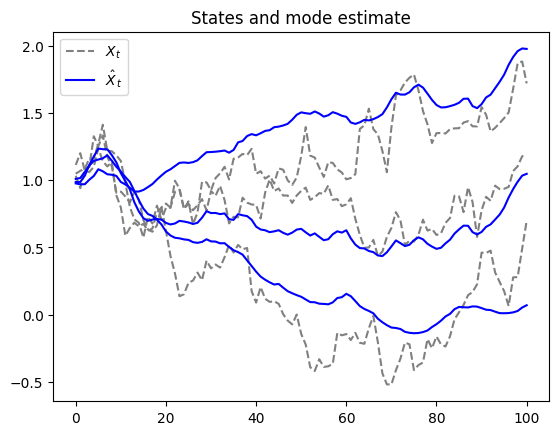

In [7]:
s_init = jnp.log(Y + 1.)
x_smooth, z, Omega = mode_estimation(Y, x0, A, Sigma, B, xi_fun, dist, s_init, 10)

plt.title("States and mode estimate")
plt.plot(X, linestyle='--', color="gray", label="$X_t$")
plt.plot(x_smooth, color="blue", label="$\\hat X_t$")

# unique legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

The default implementation of the `mode_estimation` method uses automatic differentiation to evaluate the first and second derivatives necessary to implement mode estimation. You can also provide the derivatives yourself, e.g. for efficiency or numerical stability.

In [8]:
#| code-fold: True
from jax.scipy.special import expit
def nb_log_lik(t, s):
    r, s = xi_fun(t, s)
    y_t = Y[t]

    return jnp.sum(y_t * jnp.log(expit(s - jnp.log(r))) - r * jnp.log(jnp.exp(s) + r))

def d_nb_log_lik(t,s):
    r, s = xi_fun(t, s)
    y_t = Y[t]
    return y_t - (y_t + r) * expit(s - jnp.log(r))

def dd_nb_log_lik(t,s):
    r, s = xi_fun(t, s)
    y_t = Y[t]
    return jnp.diag(- (y_t + r) * expit(s - jnp.log(r)) * (1 - expit(s - jnp.log(r))))

print("10 iterations of mode estimation with AD ")
%timeit mode_estimation(Y, x0, A, Sigma, B, xi_fun, dist, s_init, 10)[0].block_until_ready()
print("10 iterations of mode estimation without AD")
%timeit mode_estimation(Y, x0, A, Sigma, B, xi_fun, dist, s_init, 10, nb_log_lik, d_nb_log_lik, dd_nb_log_lik)[0].block_until_ready()

10 iterations of mode estimation with AD 
2.57 s ± 485 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10 iterations of mode estimation without AD
1.36 s ± 418 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
#| hide
from jax.profiler import trace

#with trace("/tmp/jax_trace/isssm/mode_estimation"):
#    mode_estimation(Y, x0, A, Sigma, B, xi_fun, dist, s_init, 10, nb_log_lik, d_nb_log_lik, dd_nb_log_lik)[0].block_until_ready()

In [10]:
#| hide
import nbdev; nbdev.nbdev_export()